In [1]:
from glob import glob
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hac
import seaborn as sns
from scipy.cluster.hierarchy import fcluster

In [2]:
def convert_to_list(bs4row):
    list_bs4row = bs4row.findAll(["td","th"])
    return [bs4.get_text().strip() for bs4 in list_bs4row]

In [3]:
'''
(1) Get abbreviations for US states
https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations
'''
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations').text
soup = BeautifulSoup(website_url,'lxml')# get the table
my_table = soup.find("table", { "class":"wikitable sortable"})

# get the table
rows=my_table.findAll("tr")

# convert to list of list
my_data = [convert_to_list(r) for r in rows[12:70]]
df_state = pd.DataFrame(my_data,columns=['Full_name','status','ISO','ANSI1','ANSI2','USPS','USCG','GPO','AP','Other_abv'])
df_state.dropna(subset=['GPO'],inplace=True)
state_abv = dict(zip(df_state['Full_name'].tolist(),df_state['USPS'].tolist()))
abv_state = dict(zip(df_state['USPS'].tolist(),df_state['Full_name'].tolist()))
with open('US_state_code_to_full.csv','w') as f:
    for abv in abv_state:
        f.write('{},{}\n'.format(abv,abv_state[abv]))

In [4]:
'''
(2) Get annunal net migration rate for US states
https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?src=CF
'''

fns = glob('Data/*_PEPTCOMP_with_ann.csv')
col_match_tail = " - Net Migration - Total"
col_match_head = 'Annual Estimates'

dict_year_netimg = {}
for fn in fns:
    df = pd.read_csv(fn,skiprows=1)
    df_state = df[df['Geography'].isin(state_abv.keys())]
    target_col = [col for col in df.columns if col.endswith(col_match_tail) and col.startswith(col_match_head)][0]
    d_temp = dict(zip(df_state['Geography'].tolist(),df_state[target_col].to_list()))
    dict_year_netimg[fn.split("_")[1]] = d_temp
    
df_mig = pd.DataFrame(index = state_abv.keys())
for year in dict_year_netimg:
    df_mig[year] = df_mig.index.map(dict_year_netimg[year])

df_mig.dropna(axis=0,inplace=True)

In [5]:
'''
(3) Get population in US states in 2018
source: https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population
'''
website_url = requests.get('https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population').text
soup = BeautifulSoup(website_url,'lxml')# get the table
my_table = soup.find("table", { "class":"wikitable sortable"})

# get the table
rows=my_table.findAll("tr")

# convert to list of list
header = convert_to_list(rows[0])
my_data = [convert_to_list(r) for r in rows[1:]]
df_pop = pd.DataFrame(my_data,columns=header)
list_state = df_mig.index
df_pop = df_pop[df_pop['Name'].isin(list_state)]
d_state_pop2018 = dict(zip(df_pop['Name'].tolist(),
                           [int(pop.replace(',','')) for pop in df_pop['Population estimate, July 1, 2018[4]'].tolist()]))

In [6]:
'''
(4) caluculate population by states for each year
'''
d_year_pop = {2018:d_state_pop2018}

for i in range(8):
    year = 2018 - i
    net_mig = dict(zip(df_mig.index,df_mig[str(year)]))
    d_state_pop = {}
    for state in list_state:
        d_state_pop[state] = d_year_pop[year][state]+net_mig[state]
    d_year_pop[year-1] = d_state_pop

In [7]:
'''
(5) caluculate migration rate (per 1000 people) by states
'''

df_rate = pd.DataFrame(index = list_state)
for year in range(2011,2019):
    d_state_rate = {}
    for state in list_state:
        d_state_rate[state] = df_mig.loc[state,str(year)]/d_year_pop[year][state]*1000
    df_rate[year] = df_rate.index.map(d_state_rate)    
df_rate

,2011,2012,2013,2014,2015,2016,2017,2018
Alabama,1.045663,1.192060,1.159907,1.555191,0.704403,0.789766,1.698002,1.853977
Alaska,0.999376,-0.617467,-3.089143,-11.249916,-7.069564,-3.547910,-11.495199,-11.324342
Arizona,3.618293,6.166023,4.941527,7.506323,8.522356,10.397308,10.911210,13.605663
Arkansas,2.193701,0.589794,0.308014,-0.216618,0.884729,1.166257,2.722159,1.571093
California,2.007394,2.207610,1.857695,3.256551,2.615101,0.847885,0.674920,-0.967489
Colorado,5.571255,6.221893,7.509651,8.612107,11.577663,10.489515,8.113012,9.042125
Connecticut,-1.065457,-1.026411,-0.430884,-2.596100,-2.492736,-3.598513,-1.264698,-1.403714
Delaware,3.767921,5.614696,5.415791,7.207155,7.260494,5.679235,7.384339,8.972560
District of Columbia,11.720755,12.111628,12.570716,6.803228,11.553888,8.997456,7.533566,3.781025
Florida,7.609197,8.725590,8.366588,11.114086,14.930570,14.876635,14.116285,14.473323


In [8]:
import folium

state_geo = 'Data/us-states.json'
m = folium.Map(location=[37, -102], zoom_start=5)

df_map = pd.DataFrame({'code':[state_abv[s] for s in df_rate.index],
                       'rate_2018':df_rate[2018]})
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=df_map,
    columns=['code','rate_2018'],
    key_on='feature.id',
    fill_color='RdBu',
    fill_opacity=0.5,
    line_opacity=0.2,
    threshold_scale=[-40,-30,-20,-10,0,10,20,30,40]
).add_to(m)

folium.LayerControl().add_to(m)
m

<img src="folium_output.JPG">

In [9]:
def plot_state_mig_rates(df_rate_T,list_state,fig_name):
    
    plt.figure(figsize=(12,2*((len(list_state)+4)//4)))

    for idx,state in enumerate(list_state):
        plt.subplot(len(list_state)//4+1, 4, idx+1)
        ax=sns.lineplot(data=df_rate_T[state])
        ax.set_title(state)
        ax.set_ylim([-30,30])

    plt.tight_layout()
    plt.savefig(fig_name,dpi=300)

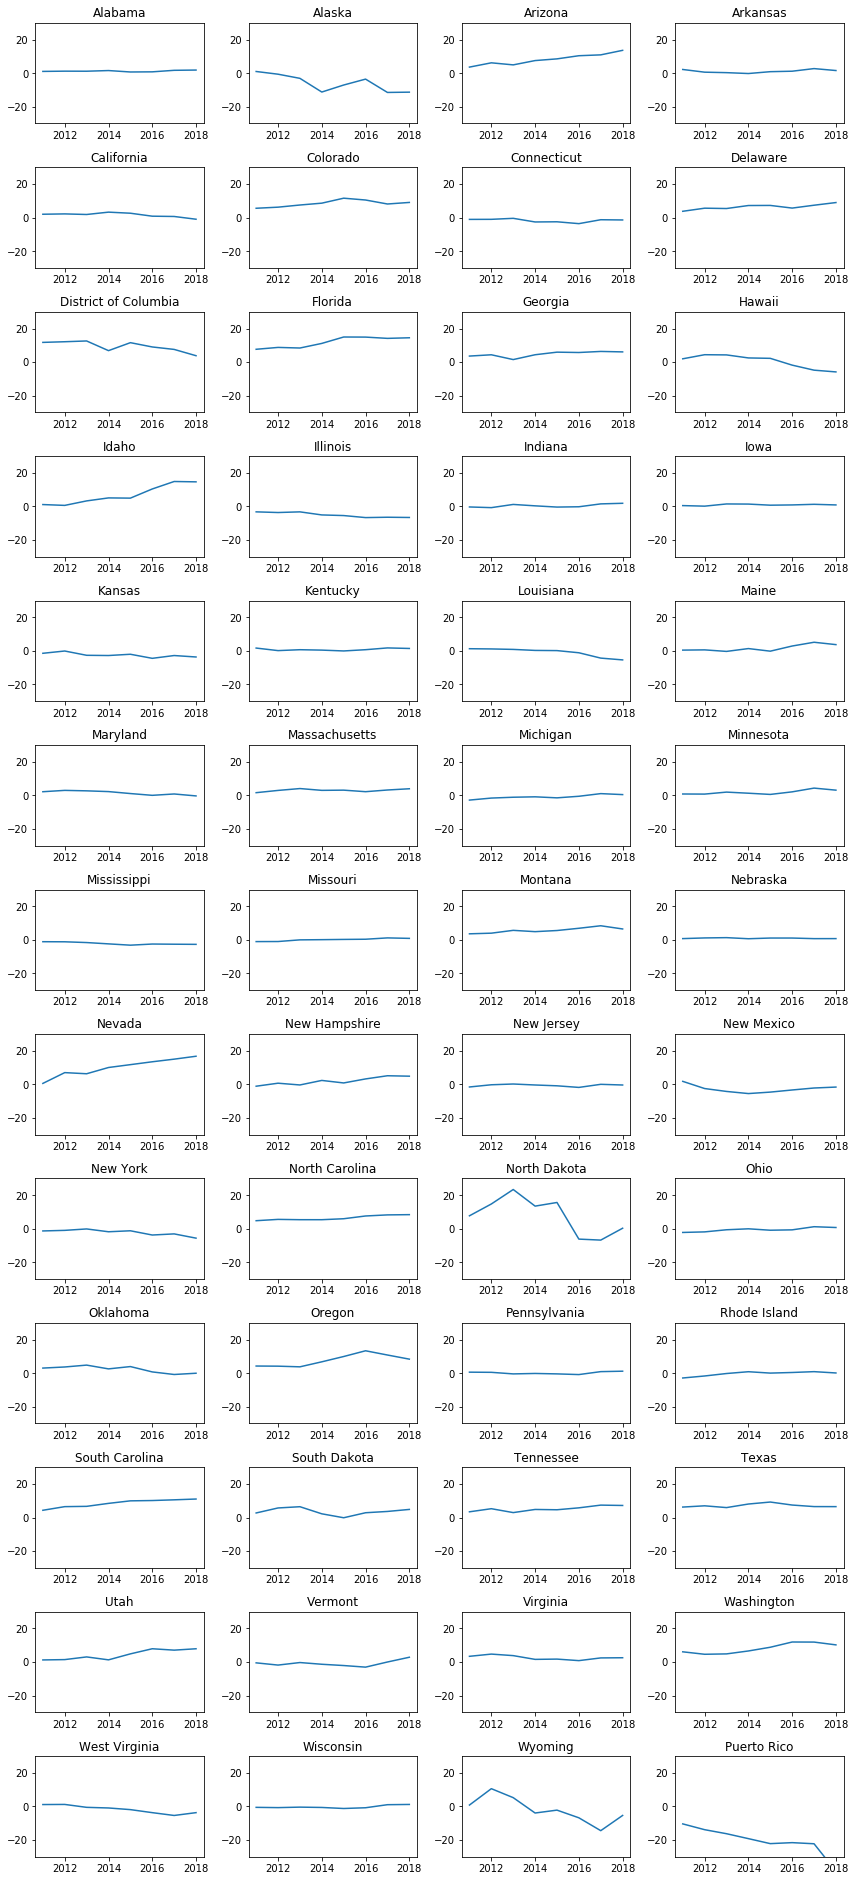

In [10]:
df_rate_T =df_rate.transpose()
plot_state_mig_rates(df_rate_T,list_state,'state_migration_rate_ALL.png')

In [11]:
def time_series_clustering_and_plot(df_rate,list_state,fig_name):

    '''
    the code is adapted from:
    https://stackoverflow.com/questions/34940808/hierarchical-clustering-of-time-series-in-python-scipy-numpy-pandas
    '''
    # Do the clustering
    df_temp = df_rate[df_rate.index.isin(list_state)]
    Z = hac.linkage(df_temp, method='single', metric='correlation')

    # Plot dendogram
    plt.figure(figsize=(12,len(list_state)//3))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('States')
    plt.ylabel('distance')
    hac.dendrogram(
        Z,
        orientation='right',
        leaf_font_size=12,  # font size for the x axis labels
        labels=df_rate.index
    )
    plt.tight_layout()
    plt.savefig(fig_name,dpi=300)
    return Z

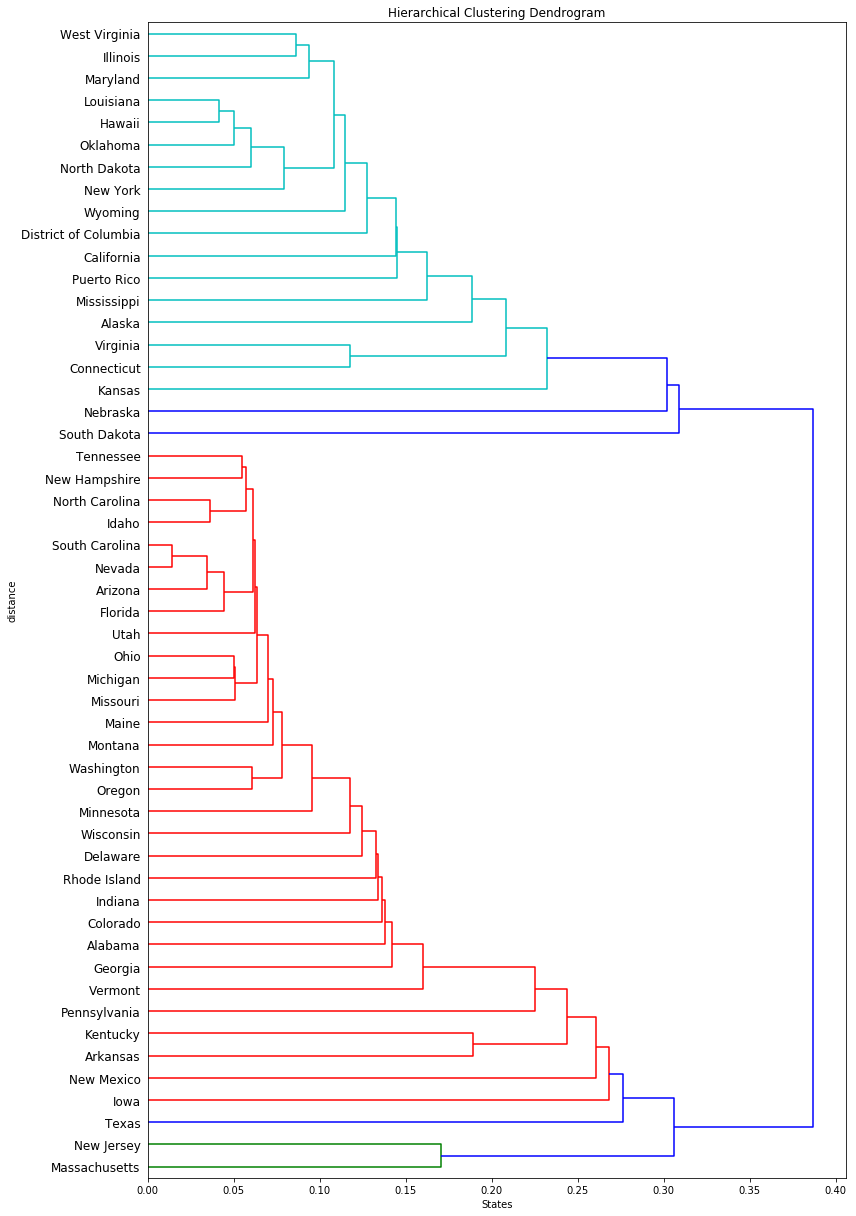

In [12]:
Z = time_series_clustering_and_plot(df_rate,list_state,"states_mig_rate_Dendrogram_ALL.png")

In [13]:
def get_dict_sub_cluster(Z,k):

    list_clusters = list(fcluster(Z,k,criterion='maxclust'))
    clusters = list(set(list_clusters))

    d_cluster_states = {}
    for cluster in clusters:
        idxes = [i for i,c in enumerate(list_clusters) if c==cluster]
        d_cluster_states[cluster] = df_rate.index[idxes].tolist()
    return d_cluster_states

In [14]:
d_cluster_states = get_dict_sub_cluster(Z,10)

with open('list_states_clustered_by_migration_pattern.csv','w') as f:
    for cluster in d_cluster_states:
        f.write(",".join([str(cluster),','.join(d_cluster_states[cluster])])+"\n")

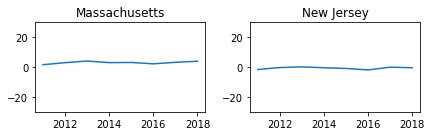

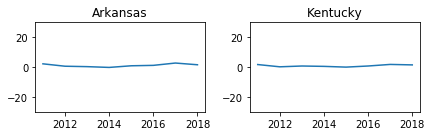

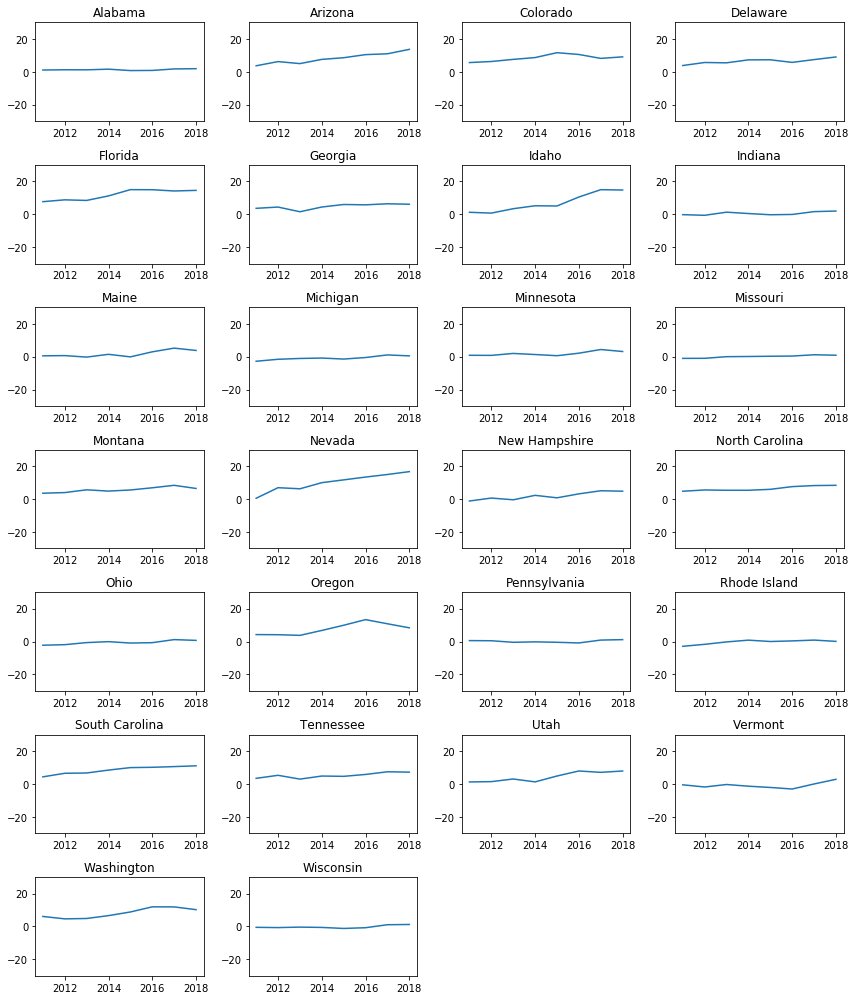

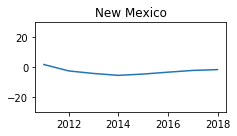

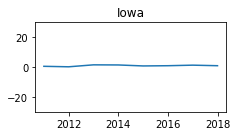

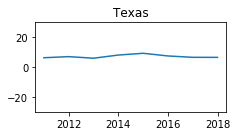

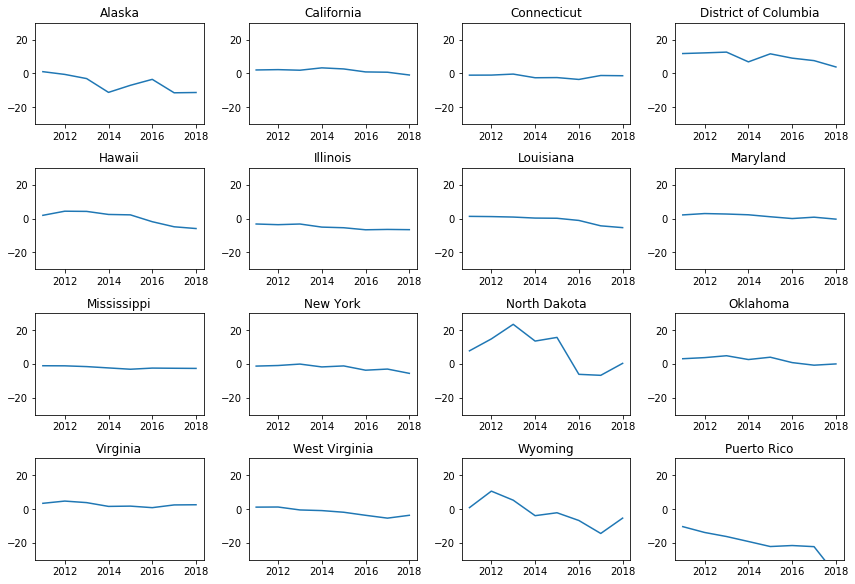

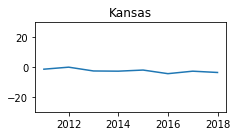

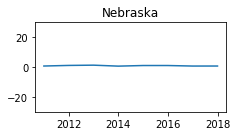

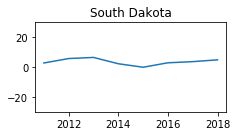

In [15]:
for cluster in d_cluster_states:
    plot_state_mig_rates(df_rate_T,d_cluster_states[cluster],"state_cluster_"+str(cluster)+".png")